In [1]:
import altair as alt
import ibis
import jupyterlab_omnisci

In [2]:
alt.data_transformers.enable('ibis')
alt.renderers.enable("extract-ibis")

RendererRegistry.enable('extract-ibis')

In [3]:
omnisci_cli = ibis.mapd.connect(
    host='metis.mapd.com', user='mapd', password='HyperInteractive',
    port=443, database='mapd', protocol= 'https'
)

In [4]:
t = omnisci_cli.table('flights_donotmodify')

In [5]:

ad = t.arrdelay.mean().name('ad')
dd = t.depdelay.mean().name('dd')
flt_bet = t.count().name('fbp')
origin = t.origin_city.name('origin')
dest = t.dest_city.name('dest')

fbp_expr = t.group_by([origin, dest]).aggregate(flt_bet)
#print(fbp_expr.compile())

expr = t\
.group_by(['origin_city','dest_city'])\
.having([ad.notnull(), dd.notnull(), ad > 10, dd > 10])\
.aggregate([ad,dd])

#print(expr.compile())

fc = fbp_expr.view()

#Create a join expr - for all pairs of cities with at least 5000 flights between the pair, 
#find where there were at least an average delay of 10 mins for both arrival and departure
join_expr = fc[(fc.fbp > 5000) ]\
.inner_join(expr,[(fc.origin == expr.origin_city),(fc.dest == expr.dest_city)])[expr, fc.fbp]\
.sort_by([('ad',False),('dd',False)]).limit(100)

#print(join_expr.compile())

chart = alt.Chart(join_expr).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='fbp:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['dd', 'ad', 'fbp'],
    column=['dd', 'ad', 'fbp']
).interactive()

altair.renderers.enable("json")

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


altair.renderers.enable("extract-json")

<IPython.core.display.JSON object>

altair.renderers.enable("extract-ibis-sql")

SELECT *
FROM (
  SELECT t2.*, "fbp"
  FROM (
    WITH t3 AS (
      SELECT "origin_city" AS origin, "dest_city" AS dest, count(*) AS fbp
      FROM flights_donotmodify
      GROUP BY origin, dest
    )
    SELECT t4.*
    FROM (
      SELECT "origin_city" AS origin, "dest_city" AS dest, count(*) AS fbp
      FROM flights_donotmodify
      GROUP BY origin, dest
    ) t4
    WHERE t4."fbp" > 5000
  ) t1
    JOIN (
      SELECT "origin_city", "dest_city", avg("arrdelay") AS ad,
             avg("depdelay") AS dd
      FROM flights_donotmodify
      GROUP BY origin_city, dest_city
      HAVING avg("arrdelay") IS NOT NULL AND avg("depdelay") IS NOT NULL AND avg("arrdelay") > 10 AND avg("depdelay") > 10
    ) t2
      ON ("origin" = t2."origin_city") AND
         ("dest" = t2."dest_city")
) t0
ORDER BY "ad" DESC, "dd" DESC
LIMIT 100

altair.renderers.enable("extract-ibis")

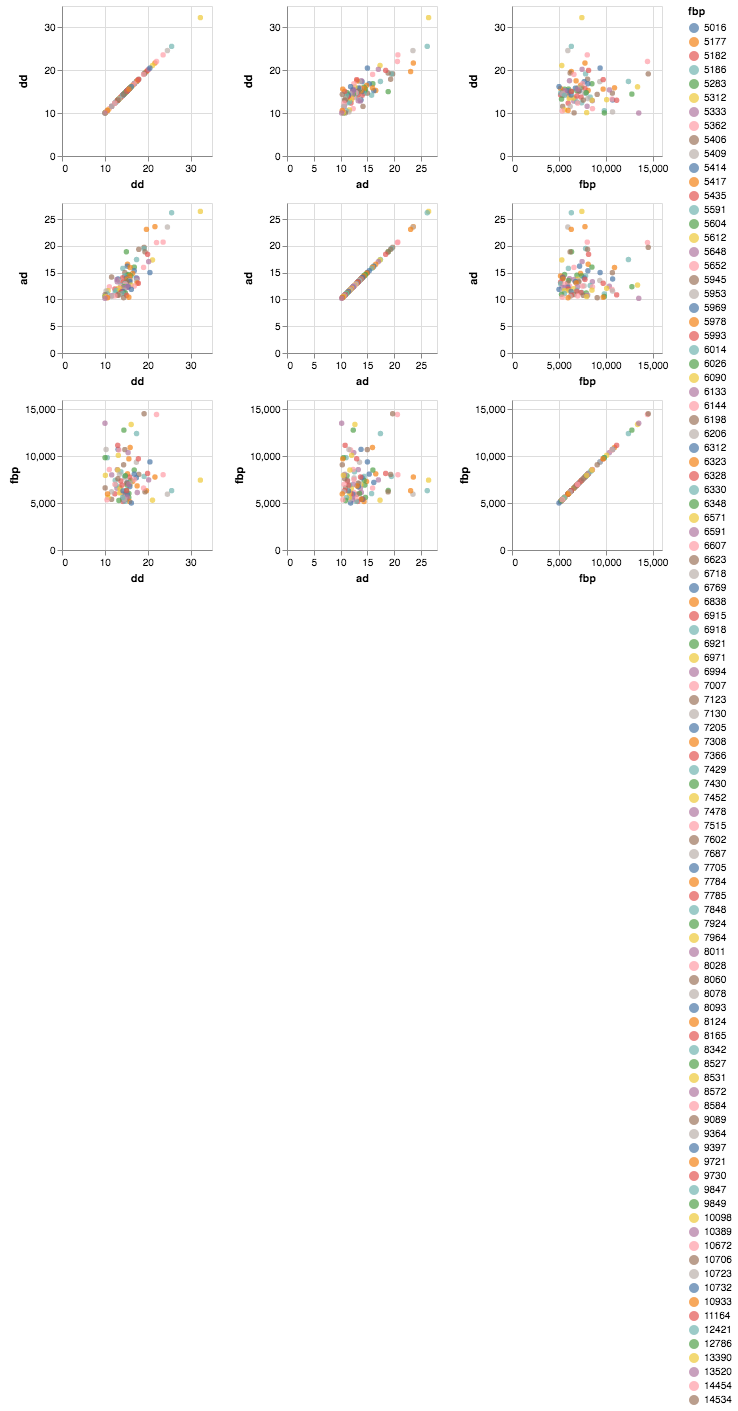

In [6]:
jupyterlab_omnisci.display_chart(chart)

OK that's weird, the extracted spec is empty! Let's try running the JSON manually though the extraction:

In [7]:
from jupyterlab_omnisci.altair import VegaLite, extract_spec, EMPTY_SPEC
import json

In [8]:

UDPATED_SPEC = None

def on_transformed(updated):
    global UDPATED_SPEC
    UDPATED_SPEC = updated

extract_spec(json.loads(chart.to_json()), on_transformed)

In [9]:
UDPATED_SPEC

OK that looks ok... Hmm...